In [32]:
import numpy as np
import pandas as pd
import os
import sys
import pickle as pkl
import matplotlib.pyplot as plt
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import seaborn as sns

sys.setrecursionlimit(10000)
%matplotlib inline
init_notebook_mode(connected=True)

pd.options.mode.chained_assignment = None # turn off SettingWithCopyWarning

# Load Parcel Data

In [33]:
names = ["event_id", "user_id", "location_id", "lon", "lat", "epoch_time", "day_id", "seconds_since_monday"]
directory = os.path.join("..", "data")  # generic
data = pd.read_csv(os.path.join(directory, "parcel_ass-oc-ass_events_no_filter.csv"), header = None, names = names)
data.sort_values(['user_id', 'epoch_time'], inplace=True)
data.describe()

,event_id,user_id,location_id,lon,lat,epoch_time,day_id,seconds_since_monday
count,6.559170e+05,6.559170e+05,655917.000000,655917.000000,655917.000000,6.559170e+05,655917.000000,655917.000000
mean,6.319007e+06,7.921562e+08,241633.977727,-117.878281,33.740011,1.441100e+09,114.426144,324717.879480
std,3.652273e+06,1.001908e+09,191189.068282,0.097180,0.104993,5.944586e+06,68.802527,174493.396071
min,8.000000e+01,2.940000e+02,9.000000,-118.115560,33.388260,1.431313e+09,1.000000,2.000000
25%,3.156263e+06,5.413332e+07,61905.000000,-117.922940,33.665890,1.436230e+09,58.000000,162146.000000
50%,6.301512e+06,2.876739e+08,211459.000000,-117.911910,33.778800,1.440782e+09,111.000000,330765.000000
75%,9.483557e+06,1.219463e+09,409421.000000,-117.837490,33.811010,1.446231e+09,174.000000,481287.000000
max,1.272555e+07,4.724669e+09,661044.000000,-117.446930,33.945950,1.452279e+09,244.000000,604798.000000


# Visits  

Moshe created visits by _replac[ing] tweets
occurring with the same hour and within 50 meters of each
other with a single effective tweet._ 

Note that the `epoch_time` column contains timestamps (not sure the timezone) with a milisecond resolution. We will use that column to create visits in a similar fashion that also incorporates the location of the tweet.

In [34]:
d = 0.05  # 50 m
t = 60**2  # number of s in one hr

def spherical_dist(pos1, r=6371):
    """
    return distance matrix in km
    
    https://stackoverflow.com/questions/19413259/efficient-way-to-calculate-distance-matrix-given-latitude-and-longitude-data-in
    """
    pos2 = np.array(pos1)
    pos1 = np.array(pos1)[:, None]
    pos1 = np.deg2rad(pos1)
    pos2 = np.deg2rad(pos2)
    cos_lat1 = np.cos(pos1[..., 0])
    cos_lat2 = np.cos(pos2[..., 0])
    cos_lat_d = np.cos(pos1[..., 0] - pos2[..., 0])
    cos_lon_d = np.cos(pos1[..., 1] - pos2[..., 1])
    return r * np.arccos(cos_lat_d - cos_lat1 * cos_lat2 * (1 - cos_lon_d))

def temporal_dist(times):
    """matrix of time differences"""
    times = np.array(times)
    return np.abs(np.subtract.outer(times, times))

def invert_dict(d): 
    """reverse a dictionary with list/set values"""
    inverse = dict() 
    for key in d: 
        for item in d[key]:
            inverse[item] = key
    return inverse

def set_visits(df):
    """
    :param df: pd.DataFrame for one user with <lat, lon, epoch_time> columns
    :return: same pd.DataFrame with a visit column containing integer visit id
    """
    # find groups of points that meet both the dist and time criteria for a visit
    distance_match = spherical_dist(df[['lat', 'lon']]) <= d
    time_match = temporal_dist(df['epoch_time']) <= t
    matches = distance_match & time_match
    groups = {}
    i = 0
    for row_i, row in enumerate(matches):
        v = list([i for i, is_true in enumerate(row) if is_true])
        if v not in groups.values():
            groups[i] = v
            i += 1
    df['visit'] = invert_dict(groups).values()
    return df

### Apply to the entire data set & save result

In [35]:
# pop = data.groupby('user_id').apply(set_visits)
# pop_deduped = pop.drop_duplicates(['user_id', 'location_id', 'visit'])
# pop.to_csv(os.path.join(directory, "parcel_ass-oc-visits-ass_events_no_filter.csv"), index=False)
# pop_deduped.to_csv(os.path.join(directory, "parcel_ass-oc-visits-ass_events_deduped.csv"), index=False)

pop = pd.read_csv(os.path.join(directory, "parcel_ass-oc-visits-ass_events_no_filter.csv"))
# pop.sort_values(['user_id', 'epoch_time'], inplace=True)
pop.shape


(655917, 9)

In [36]:
pop_deduped = pd.read_csv(os.path.join(directory, "parcel_ass-oc-visits-ass_events_deduped.csv"))
pop_deduped.sort_values(['user_id', 'epoch_time'], inplace=True)
pop_deduped.shape


(545697, 9)

## Format & filter for analysis

In [37]:
def sequential_filter_data(df, time_span='month', n_k=30):
    """
    Filter to users with at least n_k events in 2 sequential time_spans
    
    df: pd.DataFrame containing {user_id, day_id } columns 
    time_span: str in {'week', 'month', 'bimonth'}
    n_k: number of events a user must have in each time_span
    """
    t_vals = {
        'week': 7,
        'month': 30,
        'bimonth': 60,
    }
    t = t_vals.get(time_span)
    if t is None:
        return print("Enter a valid time_span... {'week', 'month', 'bimonth'}")

    # reset day id to start at 0
    df["day_id"] = df["day_id"] - df["day_id"].min()
    
    # calculate time_used ids
    df[time_span] = data.day_id // t
    
    # calc nevents in each time_span for each user & filter by min threshold
    counts = df.groupby(["user_id", time_span]).count()["event_id"]
    view = counts[counts >= n_k].reset_index()
    
    # join together to have a row for each user for a single time_span joined 
    # with the prior and next time_span
    lagged_view = pd.concat(
        [view, view.shift(1), view.shift(2)], 
        axis = 1
    )
    lagged_view.columns = list("next_" + view.columns) + \
        list(view.columns) + list("last_" + view.columns)
    
    # filter rows so that they only contain pairs where there is a sequential time_span present
    right_users = (lagged_view["user_id"] == lagged_view["next_user_id"]) | \
        (lagged_view["user_id"] == lagged_view["last_user_id"])
    sequential = ((lagged_view["next_"+time_span] - lagged_view[time_span]) == 1) | \
        ((lagged_view[time_span] - lagged_view["last_"+time_span]) == 1)
    filtered = lagged_view[right_users & sequential][["user_id", time_span, "event_id"]].reset_index(drop=True)
    
    # gather ids and valid weeks for the users that have survived the filtering
    user_time_dict = {-1 : []}
    for i, x in filtered.iterrows():
        user_id = x["user_id"]
        time = x[time_span]
        if user_id not in user_time_dict:
            user_time_dict[user_id] = []
        user_time_dict[user_id].append(time)
        
    # reduce the original data to be only valid events
    out = pd.merge(left=filtered, right=df, on=["user_id", time_span], how="left")    
    
    return out, user_time_dict


def create_mpp(df: pd.DataFrame, user_dict: dict):
    """create a dataframe contianing the data to be analyzed"""
    # get the user_ids that met the criteria in the first 2 months
    keep = []
    for uid, months in user_dict.items():
        if all(x in months for x in [0., 1.]):
            keep.append(uid)

    # create the mpp data frame
    mpp = df.loc[(df['user_id'].isin(keep)) & (df['month'].isin({0., 1.})),].reset_index()
    mpp['m'] = np.where(mpp['month'] == 0., 'a', 'b')
    
    # remap user id for easier handling
    user_dict = {}
    index = 1
    for ident in mpp.user_id.unique():
        if ident not in user_dict:
            user_dict[ident] = index
            index += 1

    mpp["new_user_id"] = mpp.user_id.apply(lambda x: user_dict[x])
    
    return mpp[['user_id', 'new_user_id', 'm', 'lon', 'lat', 'location_id']].rename(index=str, columns={"user_id": "old_uid", "new_user_id": "uid"}), keep

#     mpp["uid"] = mpp.user_id.apply(lambda x: user_dict.get(x))
#     df["uid"] = df.user_id.apply(lambda x: user_dict.get(x))
    
#     return (
#         mpp[['user_id', 'uid', 'm', 'lon', 'lat', 'location_id']].rename(index=str, columns={"user_id": "old_uid"}), 
#         keep,
#         df.rename(index=str, columns={"user_id": "old_uid"}), 
#     )

In [38]:
time_span = 'month'
n_visits = 20

filtered_visits, filtered_users = sequential_filter_data(
    pop_deduped, time_span=time_span, n_k=n_visits
)
print("FILTERED VISITS")
print("Users: ", filtered_visits['user_id'].nunique())
print("Visits:", len(filtered_visits))

FILTERED VISITS
Users:  99
Visits: 47678


In [12]:
pop_deduped.head()

,event_id,user_id,location_id,lon,lat,epoch_time,day_id,seconds_since_monday,visit,month
0,2851744.0,294.0,112474.0,-117.88171,33.67500,1.440221e+09,103.0,426190.0,0,3.0
1,8240773.0,294.0,112474.0,-117.88171,33.67500,1.440385e+09,105.0,589727.0,1,3.0
2,2523729.0,922.0,619264.0,-117.86768,33.67400,1.436486e+09,60.0,320140.0,0,3.0
3,8234911.0,1469.0,11231.0,-117.91960,33.80013,1.446830e+09,180.0,378852.0,0,3.0
4,8238747.0,1469.0,11231.0,-117.91960,33.80013,1.446834e+09,180.0,382933.0,1,3.0


In [13]:
pop_deduped.loc[(pop_deduped['month'] == 0.) | (pop_deduped['month'] == 1.)].shape
                                                

(140569, 10)

In [28]:
m0 = pd.DataFrame(pop_deduped.loc[pop_deduped['month'] == 0.].groupby('user_id').count()['event_id'])
m1 = pd.DataFrame(pop_deduped.loc[pop_deduped['month'] == 1.].groupby('user_id').count()['event_id']) 
both = m0.merge(m1, on='user_id')


In [31]:
both.loc[(both['event_id_x'] >= 20) & (both['event_id_y'] >= 20)].shape

(10, 2)

In [17]:
mpp, keep = create_mpp(filtered_visits, filtered_users)
mpp.to_csv(os.path.join(directory, "mpp_visits_month0a_month1b_n20.csv"), index=False)
print("MPP DATA (at least {} visits in each of the first two {}s)".format(n_visits, time_span))
print("Users: ", mpp['uid'].nunique())
print("Visits:", len(mpp))


MPP DATA (at least 20 visits in each of the first two months)
Users:  10
Visits: 7018


In [21]:
n_users = mpp['uid'].nunique()
print("Number of events")
print("----------------")
print("Month 1: ", sum(mpp.m == 'a'), "({} per user)".format(round(sum(mpp.m == 'a')/n_users, 1)))
print("Month 2: ", sum(mpp.m == 'b'), "({} per user)".format(round(sum(mpp.m == 'b')/n_users, 1)))


Number of events
----------------
Month 1:  4196 (419.6 per user)
Month 2:  2822 (282.2 per user)


In [12]:
mpp.head()

,old_uid,uid,m,lon,lat,location_id
0,55761838.0,1,a,-117.91729,33.84402,24505.0
1,55761838.0,1,a,-117.92222,33.63775,98039.0
2,55761838.0,1,a,-118.00284,33.85269,83232.0
3,55761838.0,1,a,-118.00951,33.85871,82559.0
4,55761838.0,1,a,-117.88178,33.82793,40522.0


In [13]:
pop_deduped.head()

,old_uid,month,event_id_x,event_id_y,location_id,lon,lat,epoch_time,day_id,seconds_since_monday,visit,uid
0,15408850.0,3.0,169.0,10652417.0,296294.0,-117.76269,33.72535,1.437872e+09,76.0,496629.0,65,NaN
1,15408850.0,3.0,169.0,1071466.0,272764.0,-117.81668,33.63148,1.437885e+09,76.0,509386.0,66,NaN
2,15408850.0,3.0,169.0,9301717.0,280551.0,-117.78394,33.70731,1.437942e+09,77.0,566566.0,67,NaN
3,15408850.0,3.0,169.0,9302242.0,280551.0,-117.78408,33.70594,1.437943e+09,77.0,566939.0,68,NaN
4,15408850.0,3.0,169.0,9357419.0,108130.0,-117.90639,33.68270,1.437954e+09,77.0,578624.0,69,NaN


# CMP Computation - Single User

### Compute bandwidths for the population data

In [32]:
from kde.location_project.kde_2d import (
    kdnearest, 
    learn_nearest_neighbors_bandwidth, 
    plot_kde,
    sample_from_kde
)

# pts = pop_deduped.loc[:, ['lon', 'lat']].values
# pop_deduped['bw'] = learn_nearest_neighbors_bandwidth(pts, k=5, min_bw=0.05)
# pop_deduped.to_csv(os.path.join(directory, "parcel_ass-oc-visits-ass_events_deduped_bw.csv"), index=False)
pop_deduped = pd.read_csv(os.path.join(directory, "parcel_ass-oc-visits-ass_events_deduped_bw.csv"))
pop_deduped.head()

,event_id,user_id,location_id,lon,lat,epoch_time,day_id,seconds_since_monday,visit,month,bw
0,2851744.0,294.0,112474.0,-117.88171,33.67500,1.440221e+09,103.0,426190.0,0,3.0,0.05
1,8240773.0,294.0,112474.0,-117.88171,33.67500,1.440385e+09,105.0,589727.0,1,3.0,0.05
2,2523729.0,922.0,619264.0,-117.86768,33.67400,1.436486e+09,60.0,320140.0,0,2.0,0.05
3,8234911.0,1469.0,11231.0,-117.91960,33.80013,1.446830e+09,180.0,378852.0,0,6.0,0.05
4,8238747.0,1469.0,11231.0,-117.91960,33.80013,1.446834e+09,180.0,382933.0,1,6.0,0.05


In [33]:
pop_deduped['bw'].describe()

count    545697.000000
mean          0.057399
std           0.042676
min           0.050000
25%           0.050000
50%           0.050000
75%           0.050000
max           2.928800
Name: bw, dtype: float64

In [38]:
pop_kde_data = np.array(pop_deduped[['user_id', 'lon', 'lat', 'bw']])

array([[ 2.94000000e+02, -1.17881710e+02,  3.36750000e+01,
         5.00000000e-02],
       [ 2.94000000e+02, -1.17881710e+02,  3.36750000e+01,
         5.00000000e-02],
       [ 9.22000000e+02, -1.17867680e+02,  3.36740000e+01,
         5.00000000e-02],
       ...,
       [ 4.71980581e+09, -1.17919840e+02,  3.38024600e+01,
         5.00000000e-02],
       [ 4.71980581e+09, -1.17920510e+02,  3.38000100e+01,
         5.00000000e-02],
       [ 4.72466857e+09, -1.17922720e+02,  3.38071200e+01,
         5.00000000e-02]])

### Get the individual component

In [41]:
def get_individual_component(df, user_id):
    # user's location set is all unique parcels visited regardless of month
    loc_set = df.loc[mpp['uid'] == user_id]['location_id'].unique()
    
    # sample space is any other users' data in either month
    samp_sp = df.loc[(df.uid != user_id)]

    # loop over users in sample space counting number of overlapped parcels
    matches = []
    for u in samp_sp.uid.unique():
        tmp = samp_sp.loc[samp_sp.uid == u]
        shared_locs = np.intersect1d(
            loc_set,
            tmp['location_id'].unique()
        )
        if len(shared_locs) > 0:
            matches.append(
                {
                    'uid': u,
                    'n_matches': len(shared_locs),
                    'n_events': len(tmp)
                }
            )
    matches = pd.DataFrame(matches)

    # compute the weight for each matching user's points
    tot_matches = sum(matches['n_matches'])
    matches['w'] = matches['n_matches'] / (tot_matches  * matches['n_events'])
    matches.drop(['n_events', 'n_matches'], axis=1, inplace=True)

    # limit the sample space
    samp_sp = pd.merge(samp_sp, matches, on='uid')
    print('USER', user_id)
    print('Number of unique locations:', len(loc_set))
    print('Number of matched users:', samp_sp.uid.nunique())
    print('Number of sample points:', len(samp_sp))
    print('Sum of weights:', round(sum(samp_sp.w), 2))
    
    return samp_sp

In [42]:
# get the sample space
user = 1
indiv_data = get_individual_component(mpp, user)

USER 1
Number of unique locations: 31
Number of matched users: 11
Number of sample points: 1253
Sum of weights: 1.0


In [43]:
indiv_data.head()

,old_uid,uid,m,lon,lat,location_id,w
0,13608552.0,3,a,-117.91900,33.81700,31808.0,0.000464
1,13608552.0,3,a,-117.91814,33.81709,31808.0,0.000464
2,13608552.0,3,a,-117.91783,33.81633,31808.0,0.000464
3,13608552.0,3,a,-117.88333,33.78950,435556.0,0.000464
4,13608552.0,3,a,-117.91867,33.85617,30171.0,0.000464


### Sample from mixture KDE

In [ ]:
def sample_from_mixture_kde(pop, indiv, n, alpha=0.1):
    sample = 
    return sample

In [84]:
# learn the bw & format for sampling
pts = samp_sp.loc[:, ['lon', 'lat']].values
bw = learn_nearest_neighbors_bandwidth(pts, k=5, min_bw=0.05)
kde_data = np.hstack(
    [
        np.atleast_2d(samp_sp['uid'].values).T,
        pts, 
        np.atleast_2d(bw).T, 
        np.atleast_2d(samp_sp['w'].values).T
    ]
)

# setup simulation
mpp_star = mpp.loc[mpp['uid'] == user]
a_star = mpp_star.loc[mpp_star['m'] == 'a']  # fix events in A^*
a_star_unique = a_star.drop_duplicates(subset='location_id')
b_star = mpp_star.loc[mpp_star['m'] == 'b'] 
b_star_unique = b_star.drop_duplicates(subset='location_id')

# PARAMETERS
n_sim = 1000
n_b_star = len(b_star_unique)
k = 1  # which nearest neighbor to use in distance computation

# do the simulation
sim = {}
scores = {}
for ell in range(n_sim):
    sim[ell] = {}
    sim[ell]['locations'] = sample_from_kde(kde_data, n=n_b_star)
    s = pd.DataFrame(sim[ell]['locations'], columns=['lon', 'lat'])
    sim[ell]['dists'] = kdnearest(a=a_star_unique, b=s, k=k)
    
    scores[ell] = {}
    scores[ell]['mean_dist'] = np.mean(sim[ell]['dists'])
    scores[ell]['med_dist'] = np.median(sim[ell]['dists'])

scores = pd.DataFrame.from_dict(scores, orient='index')
obs_dist = kdnearest(a=a_star_unique, b=b_star_unique, k=k)

Done training bandwidths


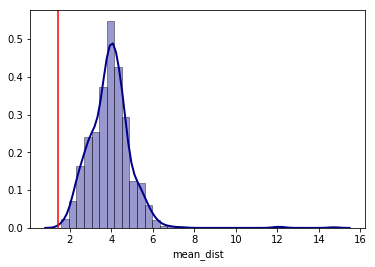

In [80]:
# mean dist to kth nn
sns.distplot(
    scores['mean_dist'], 
    hist=True, 
    kde=True, 
    bins=int(180/5), 
    color = 'darkblue', 
    hist_kws={'edgecolor':'black'},
    kde_kws={'linewidth': 2}
)
plt.axvline(np.mean(obs_dist), 0, 1, color='red')

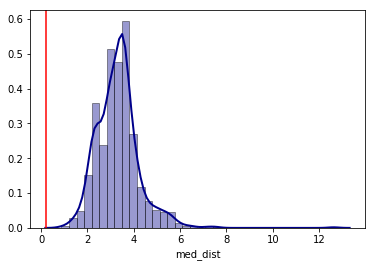

In [81]:
# median dist to kth nn
sns.distplot(
    scores['med_dist'], 
    hist=True, 
    kde=True, 
    bins=int(180/5), 
    color = 'darkblue', 
    hist_kws={'edgecolor':'black'},
    kde_kws={'linewidth': 2}
)
plt.axvline(np.median(obs_dist), 0, 1, color='red')

In [82]:
print("CMPs")
print("--------------")
print("Mean dist:", sum(scores.mean_dist < np.mean(obs_dist)) / n_sim )
print("Median dist:", sum(scores.med_dist < np.median(obs_dist)) / n_sim )

CMPs
--------------
Mean dist: 0.0
Median dist: 0.0


In [85]:
plot_kde(
    data=kde_data[:, 1:4], 
    user_data=pd.concat([a_star_unique, b_star_unique]),
    uid=user
)